In [1]:
#Make sure to comment these out if you are not using Google Collaboratory

!pip install catboost
# if you want to run in collab, uncomment the line below and make sure to cd/ls into the Boxing_punches_classification
# and run!
!git clone https://github.com/MarwanBit/P-Boxing

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.4 MB/s eta 0:00:00
Cloning into 'P-Boxing'...
remote: Enumerating objects: 276, done.
remote: Counting objects: 100% (185/185), done.
remote: Compressing objects: 100% (170/170), done.
remote: Total 276 (delta 12), reused 166 (delta 1), pack-reused 91
Receiving objects: 100% (276/276), 85.53 MiB | 14.23 MiB/s, done.
Resolving deltas: 100% (14/14), done.
Updating files: 100% (217/217), done.


In [2]:
#Make sure to comment these out if you are not using google Collaboratory
!ls
%cd P-Boxing/Boxing_punches_classification/

P-Boxing  sample_data
/content/P-Boxing/Boxing_punches_classification


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn

import plotly.graph_objs as go
import plotly.express as px

from scipy.stats import moment, skew, kurtosis


from joblib import load
import os

import os
import sys


from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, f1_score, confusion_matrix, recall_score, precision_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from catboost import CatBoostClassifier

from joblib import dump, load

In [4]:
'''
This cell will concern itself with declaring all of the functionality of the
data processing steps, alot of the functions for data processing
'''
def skip_fun(x):
    return x in (0, 1, 2)

cwd = os.getcwd()
print(cwd)

/content/P-Boxing/Boxing_punches_classification


In [5]:
'''
Now we will create a segment which will load up all the files for a given folder, for this example we will consier train_M
'''
train_M_path = "data/train_file/train_M/"
train_d1_path = "data/train_file/train_d1/"
train_B_path = "data/train_file/train_B/"

train_M = os.listdir(train_M_path)
train_B = os.listdir(train_B_path)
train_d1 = os.listdir(train_d1_path)
#Now we will iterate through the folders
#Now let's load this file
first_file_path = train_M_path + train_M[0]
#Now let's try loading this first file


In [6]:
# A function that processes all files from a folder
# until the markup.
# The parameters (wind_size, action_max, action_min) for each folder
# were selected in the last paragraph.
def raw_data_to_ready_markup_data(data_path, wind_size, action_max, action_min):
  data_train = pd.DataFrame()
  i = 0
  dir = os.listdir(data_path)
  dir.sort()
  for file_name in dir:
      data_i = pd.read_csv(data_path + file_name, skiprows=skip_fun)
      data_i["file_ind"] = i
      data_train = pd.concat([data_train, data_i], ignore_index=True)
      i += 1
  data_train.rename(columns={"Time (s)": "Time",
                      " X (m/s2)": "X",
                      " Y (m/s2)": "Y",
                      " Z (m/s2)": "Z",
                      " R (m/s2)": "R",
                      " Theta (deg)": "Theta",
                      " Phi (deg)": "Phi",}, inplace=True)

  data_train.sort_values(by=["file_ind", "Time"], inplace=True)

  data_train_filt = data_train.copy()

  for i in ["X", "Y", "Z", "R", "Theta", "Phi"]:
      data_train_filt[i] = data_train_filt[[i]].rolling(5).mean()
      data_train_filt.loc[range(4), [i]] = data_train.loc[range(4), [i]]

  data_train_filt["win_ind"] = data_train_filt.index // wind_size

  data_win = data_train_filt.loc[:, ["R", "win_ind"]]\
      .groupby("win_ind")\
      .aggregate(lambda x: int((x.max() > action_max) or (x.min() < action_min)))\
      .rename(columns={"R": "Active"})\
      .reset_index()

  data_train_filt = pd.merge(data_train_filt, data_win, how='outer', on='win_ind')

  data_train_filt["action_index"] = 0
  action_ind = 0
  for i in range(1, data_train_filt.shape[0]):
      if data_train_filt.loc[i, "Active"] != data_train_filt.loc[i - 1, "Active"]:
          action_ind += 1
      data_train_filt.loc[i, "action_index"] = action_ind

  return(data_train_filt)

In [7]:
data_train_M = raw_data_to_ready_markup_data("data/train_file/train_M/",
                                             100, 13.5, 7)
data_train_B = raw_data_to_ready_markup_data("data/train_file/train_B/",
                                             50, 13, 7)
data_train_D1 = raw_data_to_ready_markup_data("data/train_file/train_d1/",
                                             100, 12, 7)


In [8]:
data_train_M["real_action"] = 0

jab_ind = [1, 5, 7, 9, 11, 31, 33, 35, 37, 39, 61, 63, 65, 67, 69,
           93, 95, 97, 99, 103, 131, 133, 135, 137, 139, 161, 163, 165, 167, 169,
           191, 193, 195, 197, 199, 223, 225, 227, 229, 231, 253, 255, 257, 259, 261,
           283, 285, 287, 289, 291, 313, 315, 317, 319, 321, 345, 347, 349, 351, 353,
           377, 381, 383, 385, 387, 389, 415, 417, 419, 421, 423, 425, 447, 449, 451, 453, 455,
           481, 483, 485, 487, 489, 513, 515, 517, 519, 521, 549, 551, 553, 555, 557, 559,
           589, 615, 617, 619, 621, 623, 647, 649, 651, 653, 655, 683, 689,
           719, 721, 723, 725, 727, 751, 753, 755, 757, 759, 789, 793, 795, 797, 799, 801, 803, 805, 807]

uppercut_ind = [13, 15, 17, 19, 41, 43, 45, 47, 49, 71, 73, 75, 77, 79,
                107, 111, 113, 115, 117, 141, 143, 145, 147, 149, 171, 173, 175, 177, 179,
                201, 203, 205, 207, 209, 233, 235, 237, 239, 241, 263, 265, 267, 269, 271,
                293, 295, 297, 299, 301, 323, 325, 327, 329, 331, 355, 357, 359, 361, 363,
                391, 393, 395, 397, 399, 427, 429, 431, 433, 457, 459, 461, 465, 467,
                491, 493, 495, 497, 499, 523, 525, 527, 529, 531, 561, 563, 571,
                593, 595, 597, 599, 601, 625, 627, 629, 631, 633, 657, 659, 661, 663, 665,
                693, 695, 697, 699, 701, 703, 729, 731, 733, 735, 737, 761, 765, 767, 771, 773]

hook_ind = [21, 23, 25, 27, 29, 51, 53, 55, 57, 59, 81, 83, 85, 87, 89, 91,
            119, 121, 123, 125, 127, 151, 153, 155, 157, 159, 181, 183, 185, 187, 189,
            211, 213, 215, 217, 219, 221, 243, 245, 247, 249, 251, 273, 275, 277, 279, 281,
            303, 305, 307, 309, 311, 333, 335, 339, 341, 343, 365, 367, 369, 371, 373,
            401, 403, 407, 409, 435, 437, 439, 441, 443, 469, 471, 473, 475, 477,
            501, 503, 505, 507, 509, 535, 537, 539, 541, 543, 545, 579, 581, 583,
            603, 605, 607, 609, 611, 635, 639, 641, 667, 669, 671, 673, 675, 677,
            705, 707, 709, 711, 713, 739, 741, 743, 745, 747, 775, 777, 781, 783, 785]

data_train_M.loc[data_train_M["action_index"].isin(jab_ind), "real_action"] = 1
data_train_M.loc[data_train_M["action_index"].isin(uppercut_ind), "real_action"] = 2
data_train_M.loc[data_train_M["action_index"].isin(hook_ind), "real_action"] = 3

In [9]:
data_train_B["real_action"] = 0

jab_ind = [0, 2, 4, 6, 8,
           144, 148, 152]

uppercut_ind = [10, 14, 18, 22, 26, 30, 34, 36, 40, 44,
                92, 96, 98, 102, 104, 106, 108,
                158, 162, 164, 166, 170, 174, 180, 182, 184, 188]

hook_ind = [48, 54, 58, 62, 68, 72, 74, 78, 82, 86,
            110, 114, 118, 122, 126, 128, 130, 134, 136, 140,
            192, 196, 202, 208, 212, 218, 222, 224, 228, 232]

data_train_B.loc[data_train_B["action_index"].isin(jab_ind), "real_action"] = 1
data_train_B.loc[data_train_B["action_index"].isin(uppercut_ind), "real_action"] = 2
data_train_B.loc[data_train_B["action_index"].isin(hook_ind), "real_action"] = 3

In [10]:
data_train_D1["real_action"] = 0

jab_ind = [2, 4, 6, 8, 10, 12, 14,
           56, 58, 60, 62, 64, 66, 68, 70]

uppercut_ind = [16, 18, 20, 22, 24, 26, 28, 30, 32, 34,
                72, 74, 76, 78, 80, 82, 84, 86, 88, 90]

hook_ind = [36, 38, 40, 42, 44, 46, 48, 50, 52, 54,
            92, 94, 96, 98, 100, 102, 104, 106, 108, 110]

data_train_D1.loc[data_train_D1["action_index"].isin(jab_ind), "real_action"] = 1
data_train_D1.loc[data_train_D1["action_index"].isin(uppercut_ind), "real_action"] = 2
data_train_D1.loc[data_train_D1["action_index"].isin(hook_ind), "real_action"] = 3

In [11]:
data_test_B = raw_data_to_ready_markup_data("data/test_file/test_B/",
                                             125, 14, 7)
data_test_M = raw_data_to_ready_markup_data("data/test_file/test_M/",
                                             125, 12, 7)
data_test_D1 = raw_data_to_ready_markup_data("data/test_file/test_d1/",
                                             100, 12, 7)
data_test_D2 = raw_data_to_ready_markup_data("data/test_file/test_d2/",
                                             25, 13.5, 6.5)

In [12]:
data_test_B["real_action"] = 0

jab_ind = [1, 3, 13, 15]

uppercut_ind = [5, 7, 19, 21]

hook_ind = [9, 11, 23, 27]

data_test_B.loc[data_test_B["action_index"].isin(jab_ind), "real_action"] = 1
data_test_B.loc[data_test_B["action_index"].isin(uppercut_ind), "real_action"] = 2
data_test_B.loc[data_test_B["action_index"].isin(hook_ind), "real_action"] = 3

In [13]:
data_test_M["real_action"] = 0

jab_ind = [1, 3, 13, 15, 25, 27, 37, 39, 49, 51, 61, 63]

uppercut_ind = [5, 7, 17, 19, 29, 31, 41, 43, 53, 55, 65, 67]

hook_ind = [9, 11, 21, 23, 33, 35, 45, 47, 57, 59, 69, 71]

data_test_M.loc[data_test_M["action_index"].isin(jab_ind), "real_action"] = 1
data_test_M.loc[data_test_M["action_index"].isin(uppercut_ind), "real_action"] = 2
data_test_M.loc[data_test_M["action_index"].isin(hook_ind), "real_action"] = 3

In [14]:
data_test_D1["real_action"] = 0

jab_ind = [1, 3, 13, 15]

uppercut_ind = [5, 7, 17, 19]

hook_ind = [9, 11, 21, 23]

data_test_D1.loc[data_test_D1["action_index"].isin(jab_ind), "real_action"] = 1
data_test_D1.loc[data_test_D1["action_index"].isin(uppercut_ind), "real_action"] = 2
data_test_D1.loc[data_test_D1["action_index"].isin(hook_ind), "real_action"] = 3

In [15]:
data_test_D2["real_action"] = 0

jab_ind = [9, 23, 25]

uppercut_ind = [11, 13, 27, 29]

hook_ind = [15, 21, 31, 35]

data_test_D2.loc[data_test_D2["action_index"].isin(jab_ind), "real_action"] = 1
data_test_D2.loc[data_test_D2["action_index"].isin(uppercut_ind), "real_action"] = 2
data_test_D2.loc[data_test_D2["action_index"].isin(hook_ind), "real_action"] = 3

In [16]:
data_train_M

,Time,X,Y,Z,R,Theta,Phi,file_ind,win_ind,Active,action_index,real_action
0,0.000000,2.626666,9.605117,-0.391113,9.965471,92.249260,74.705528,0,0,0,0,0
1,0.002492,2.629061,9.648235,-0.525262,10.013806,93.006760,74.757462,0,0,0,0,0
2,0.004984,2.607502,9.645840,-0.642641,10.012706,93.679916,74.873123,0,0,0,0,0
3,0.007475,2.571569,9.676982,-0.731274,10.039508,94.177109,75.118118,0,0,0,0,0
4,0.009967,2.601273,9.646319,-0.617728,10.011068,93.536240,74.908119,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
416015,24.509064,0.030902,1.152355,9.273292,9.344959,7.096107,88.570166,24,4160,0,814,0
416016,24.511562,0.082645,1.192120,9.288144,9.365162,7.341780,86.206181,24,4160,0,814,0
416017,24.514059,0.126722,1.229011,9.291019,9.373410,7.584744,84.312027,24,4160,0,814,0
416018,24.516556,0.166967,1.272609,9.274250,9.363233,7.890777,82.676460,24,4160,0,814,0


In [17]:
#Now we combine the datasets
data_test_M["action_index"] += data_test_B.action_index.max() + 1
data_test_D1["action_index"] += data_test_M.action_index.max() + 1
data_test_D2["action_index"] += data_test_D1.action_index.max() + 1
data_train_B["action_index"] += data_train_M.action_index.max() + 1
data_train_D1["action_index"] += data_train_B.action_index.max() + 1

#Now we combine them all into one big dataset
data_train_full = pd.concat([data_train_M, data_train_B, data_train_D1], ignore_index=True)
data_test_full = pd.concat([data_test_B, data_test_M, data_test_D1, data_test_D2], ignore_index=True)

#additionally, we take only the punches
data_train_full = data_train_full[data_train_full["real_action"] != 0]
data_test_full = data_test_full[data_test_full["real_action"] != 0]

In [18]:
#Here are some functions which we will use for calculating some things!
# A function that counts the number of signal crossings of its average value
def n_cross(x):
    x_del = x - x.mean()
    return (np.diff(np.sign(x_del)) != 0).sum()

# A function that counts the number of points
# where the signal is greater than the maximum value of the sensor
def n_sensor_limit_max(x):
    return (x >= 77).sum()

# A function that counts the number of points
# where the signal is greater than the minimum value of the sensor
def n_sensor_limit_min(x):
    return (x <= -77).sum()

In [19]:
# Now we calculate statistical features for the dataset
data_feature_train_acc = data_train_full.loc[:, ["X", "Y", "Z", "R", "action_index"]]\
    .groupby("action_index").aggregate([
    lambda x: x.mean(),
    lambda x: x.std(),
    lambda x: x.max(),
    lambda x: x.min(),
    lambda x: x.max() - x.min(),
    lambda x: np.percentile(x, 25),
    lambda x: np.percentile(x, 50),
    lambda x: np.percentile(x, 75),
    lambda x: moment(x, moment=3),
    lambda x: moment(x, moment=4),
    lambda x: skew(x),
    lambda x: kurtosis(x),
    lambda x: n_cross(x),
    lambda x: n_sensor_limit_max(x),
    lambda x: n_sensor_limit_min(x)])

# Remove transformation artifacts
data_feature_train_acc = data_feature_train_acc.T.reset_index().T.drop(["level_0", "level_1"])
data_feature_train_acc = data_feature_train_acc.apply(lambda x: x.astype(float))


'''

Now we are doing a similar process for the gyroscopic feature data


'''

# Similarly for the gyroscope
data_feature_train_cor = data_train_full.loc[:, ["Theta", "Phi", "action_index"]]\
    .groupby("action_index").aggregate([
    lambda x: x.mean(),
    lambda x: x.std(),
    lambda x: x.max(),
    lambda x: x.min(),
    lambda x: x.max() - x.min(),
    lambda x: np.percentile(x, 25),
    lambda x: np.percentile(x, 50),
    lambda x: np.percentile(x, 75),
    lambda x: skew(x),
    lambda x: kurtosis(x),
    lambda x: n_cross(x),
    lambda x: n_sensor_limit_max(x),
    lambda x: n_sensor_limit_min(x)])

data_feature_train_cor = data_feature_train_cor.T.reset_index().T.drop(["level_0", "level_1"])
data_feature_train_cor = data_feature_train_cor.apply(lambda x: x.astype(float))

In [20]:
# Now we combine both of these into one big dataset of both features
data_feature_train_acc.reset_index(inplace=True)
data_feature_train_cor.reset_index(inplace=True)
X_train = pd.merge(data_feature_train_acc, data_feature_train_cor, on="action_index")
X_train.drop("action_index", axis=1, inplace=True)

#Additionally we get the labels
y_train = data_train_full.loc[:, ["real_action", "action_index"]]\
             .groupby("action_index").aggregate(lambda x: list(set(x))[0]).real_action

In [21]:
# Now we must do the same process for the testing dataset
# Similarly for the test dataset
data_feature_test_acc = data_test_full.loc[:, ["X", "Y", "Z", "R", "action_index"]]\
    .groupby("action_index").aggregate([
    lambda x: x.mean(),
    lambda x: x.std(),
    lambda x: x.max(),
    lambda x: x.min(),
    lambda x: x.max() - x.min(),
    lambda x: np.percentile(x, 25),
    lambda x: np.percentile(x, 50),
    lambda x: np.percentile(x, 75),
    lambda x: moment(x, moment=3),
    lambda x: moment(x, moment=4),
    lambda x: skew(x),
    lambda x: kurtosis(x),
    lambda x: n_cross(x),
    lambda x: n_sensor_limit_max(x),
    lambda x: n_sensor_limit_min(x)])

data_feature_test_acc = data_feature_test_acc.T.reset_index().T.drop(["level_0", "level_1"])
data_feature_test_acc = data_feature_test_acc.apply(lambda x: x.astype(float))

'''

DIVIDER FOR THE GYROSCOPE DATA

'''

#Now do this for the gyroscope data


data_feature_test_cor = data_test_full.loc[:, ["Theta", "Phi", "action_index"]]\
    .groupby("action_index").aggregate([
    lambda x: x.mean(),
    lambda x: x.std(),
    lambda x: x.max(),
    lambda x: x.min(),
    lambda x: x.max() - x.min(),
    lambda x: np.percentile(x, 25),
    lambda x: np.percentile(x, 50),
    lambda x: np.percentile(x, 75),
    lambda x: skew(x),
    lambda x: kurtosis(x),
    lambda x: n_cross(x),
    lambda x: n_sensor_limit_max(x),
    lambda x: n_sensor_limit_min(x)])

data_feature_test_cor = data_feature_test_cor.T.reset_index().T.drop(["level_0", "level_1"])
data_feature_test_cor = data_feature_test_cor.apply(lambda x: x.astype(float))

In [22]:
#Now we combine both to get our test dataset
data_feature_test_acc.reset_index(inplace=True)
data_feature_test_cor.reset_index(inplace=True)
X_test = pd.merge(data_feature_test_acc, data_feature_test_cor, on="action_index")
X_test.drop("action_index", axis=1, inplace=True)

y_test = data_test_full.loc[:, ["real_action", "action_index"]]\
             .groupby("action_index").aggregate(lambda x: list(set(x))[0]).real_action


In [23]:
#Now let's visualize the datasets
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(481, 86)
(481,)
(71, 86)
(71,)


# **DATA PROCESSING FINISHED: TIME TO TRAIN MODELS**


In [24]:
#Now let's try the CatBoost algorithm
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=13)
cat_score_train = []
cat_score_test = []

In [25]:
for n_tree in [250, 275, 300, 325, 350, 400]:
    ctb = CatBoostClassifier(random_seed=17, iterations=n_tree, auto_class_weights="Balanced")
    cv_scores_train = []
    cv_scores_test = []
    for train_idx, test_idx in skf.split(X_train, y_train):
        cv_train_df, cv_valid_df = (X_train.iloc[train_idx, :],
                                    X_train.iloc[test_idx, :])
        y_cv_train, y_cv_valid = y_train.iloc[train_idx], y_train.iloc[test_idx]

        ctb.fit(cv_train_df, y_cv_train)

        cv_scores_train.append(roc_auc_score(y_cv_train, ctb.predict_proba(cv_train_df), multi_class="ovr"))
        cv_scores_test.append(roc_auc_score(y_cv_valid, ctb.predict_proba(cv_valid_df), multi_class="ovr"))
    cat_score_train.append(np.mean(cv_scores_train))
    cat_score_test.append(np.mean(cv_scores_test))

Streaming output truncated to the last 5000 lines.
63:	learn: 0.0564323	total: 2.82s	remaining: 11.5s
64:	learn: 0.0558565	total: 2.88s	remaining: 11.5s
65:	learn: 0.0550451	total: 2.95s	remaining: 11.6s
66:	learn: 0.0542270	total: 3.02s	remaining: 11.7s
67:	learn: 0.0534380	total: 3.1s	remaining: 11.7s
68:	learn: 0.0517181	total: 3.18s	remaining: 11.8s
69:	learn: 0.0508090	total: 3.25s	remaining: 11.9s
70:	learn: 0.0499454	total: 3.34s	remaining: 11.9s
71:	learn: 0.0488401	total: 3.42s	remaining: 12s
72:	learn: 0.0477342	total: 3.49s	remaining: 12.1s
73:	learn: 0.0473088	total: 3.55s	remaining: 12s
74:	learn: 0.0465659	total: 3.63s	remaining: 12.1s
75:	learn: 0.0454359	total: 3.7s	remaining: 12.1s
76:	learn: 0.0449725	total: 3.78s	remaining: 12.2s
77:	learn: 0.0445542	total: 3.87s	remaining: 12.3s
78:	learn: 0.0439479	total: 3.95s	remaining: 12.3s
79:	learn: 0.0438243	total: 4.02s	remaining: 12.3s
80:	learn: 0.0430154	total: 4.11s	remaining: 12.4s
81:	learn: 0.0423569	total: 4.18s	rem

In [26]:
cat_score_train
cat_score_test

[0.9960660002976971,
 0.9945271721632609,
 0.9946083902370347,
 0.9948539440629964,
 0.9949556371132411,
 0.9948777124944552]

In [30]:
predict = ctb.predict(X_test)
sklearn.metrics.accuracy_score(y_test, predict)
dump(ctb, "simple_catboost.joblib")

['simple_catboost.joblib']

In [ ]:
X_train = X_train.to_numpy()
y_train = y_train.to_numpy()
y_train.shape
np.reshape(y_train, (481, 1))

AttributeError: ignored

In [ ]:
X_test = X_test.to_numpy()
y_test = y_test.to_numpy()
y_test.shape
np.reshape(y_train, (71, 1))

AttributeError: ignored

In [ ]:
#Now let's try support vector machines
clf = sklearn.svm.SVC()
clf.fit(X_train, y_train)

SVC()

In [ ]:
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.preprocessing import LabelBinarizer
from sklearn import metrics

In [ ]:
classif = OneVsRestClassifier(estimator=SVC(random_state=0))

In [ ]:
predictions = classif.fit(X_train, y_train).predict(X_test)
predictions

array([2, 1, 2, 2, 3, 3, 2, 1, 2, 2, 3, 3, 1, 1, 3, 2, 3, 1, 1, 1, 3, 2,
       3, 1, 1, 1, 3, 2, 1, 1, 1, 1, 3, 2, 3, 1, 1, 1, 3, 2, 3, 2, 1, 1,
       3, 2, 3, 2, 2, 1, 2, 2, 2, 1, 2, 1, 2, 2, 2, 1, 1, 2, 3, 3, 3, 2,
       1, 2, 1, 3, 3])

In [ ]:
#This dumps the trained model into a joblib file, which we can use to save models
dump(classif, "basic_svm.joblib")

['basic_svm.joblib']

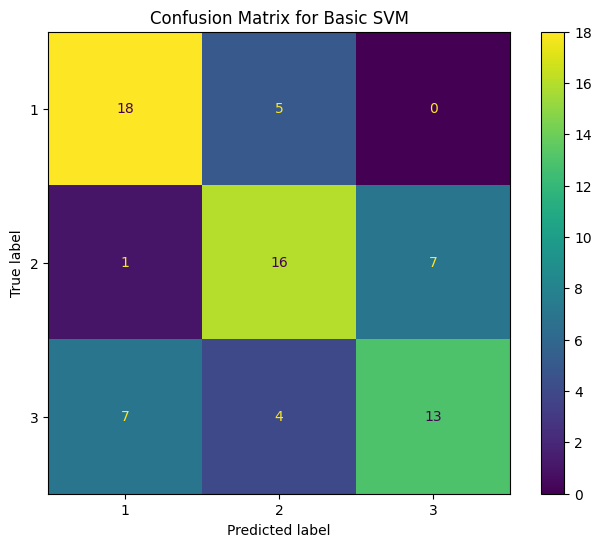

In [ ]:
#Now let's get some metrics for the
# Anya: (We should have a table of the following organizational structureal)
# Model Type | Model filename/ version | associated metrics ......
#Keeping track of these through some table!!

# Let's get some metrics for classif
#This is for hte model "basic_svm.joblib"
#Predictions is the predictions for the

#Recall, F1Score, Precision, Accuracy, Confusion Matrix, etc
#function called logmetrics in scikit learn
#ML Flow is a cool tool to explore

#More import statements for metrics

#Here's some notes on how to do this
# https://proclusacademy.com/blog/practical/confusion-matrix-accuracy-sklearn-seaborn/
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay


accuracy = metrics.accuracy_score(y_test, predictions)
conf_matrix = metrics.confusion_matrix(y_test, predictions)
conf_matrix



# Change figure size and increase dpi for better resolution
# and get reference to axes object
fig, ax = plt.subplots(figsize=(8,6), dpi=100)
ax.set(title='Confusion Matrix for Basic SVM')
ConfusionMatrixDisplay(conf_matrix, display_labels= classif.classes_)
display.plot(ax = ax)

In [ ]:
#Ok now let's get more data